<a href="https://colab.research.google.com/github/Non-NeutralZero/datascience-dev-helpers/blob/master/RandomForests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Random forests are built from decision trees
1. Initially, the original data is bootstrapped by randomly sampling the data and creating a new dataset with the same size as the original one (to be able to do that, duplicated obs are allowed - aka random sampling with replacement)
1. Build a decision tree based on the bootsrapped data
1. Randomly select features (typically sqrt(n_features)) from the bootsrapped data when splitting nodes (this is called random subspace method)
1. Go back to step 1 and repeat

*   ***does all the original data end up in the sampled subsets?*** For each created Decision Tree, the non-bootsrapped data is called **Out-of-Bag** data. 
*   ***once we get the forest, how do we use it?*** if we want to get a prediction, we run an obs through all the trees of the forest and pick the prediction with the most votes. (this process is called **Bagging**, i.e. **B**ootsrapping + **agg**regating single predictions)
*   ***how do we evaluate the random forest?*** we can evaluate it using the out-of-bag error, i.e. measure how accurate the forest predicts out-of-bag data. 
*   ***is there an optimal number of features for each bootsrapped sample?*** Yes. Given that we can measure the out-of-bag error, we can use it to compare forests built on different samples of features and select the one with the smallest error.
*   ***how many times should we repeat this processes?*** plot OOB error rate vs. number of trees 
*   ***Why are they called random forests?*** Because of the random sampling concept at step 1 and at step 3 
*   ***how is a forest better than one decision tree?*** By getting a large number of different (high variance ) trees 


For more, see Chapter 15 in https://web.stanford.edu/~hastie/Papers/ESLII.pdf





/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


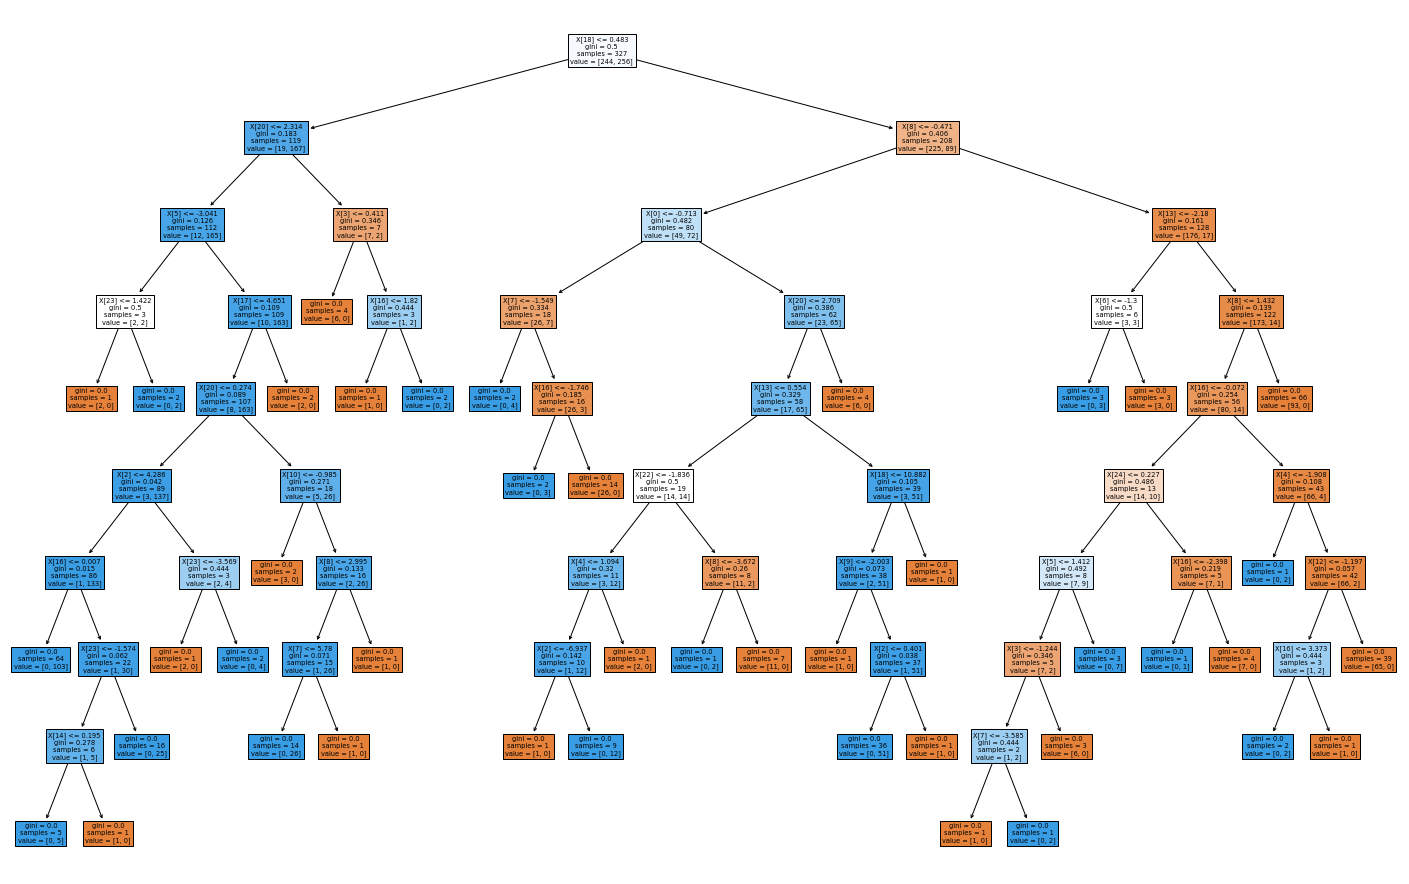

In [1]:
# does all the original data end up in the sampled subsets?
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import forest
from sklearn import tree
import random
import matplotlib.pyplot as plt

RANDOM_STATE = 890
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

clf = RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt", random_state=RANDOM_STATE)
clf.fit(X,y)

# let's pick a tree from the forest randomly
rand_tree_id = random.randrange(0, 100)
rand_tree = clf.estimators_[rand_tree_id]

# let's plot it to see how it's built
plt.figure(figsize=(25,16))
tree.plot_tree(rand_tree, filled=True, impurity=True)
plt.show()


In [2]:
import numpy as np

n_samples = X.shape[0]

# let's pick a tree from the forest randomly
rand_tree_id = random.randrange(0, 100)
rand_tree = clf.estimators_[rand_tree_id]
oob_indices = forest._generate_unsampled_indices(rand_tree.random_state,n_samples,n_samples)

print("There are {0} out of bag samples".format(X[oob_indices].shape))
print("The percentage of OOB data out of the total training data is", 100* X[oob_indices].shape[0] / X.shape[0])

print("Ideally, about 36.8% of the total training data should yield an OOB sample.") 
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.metrics import accuracy_score
estimator = clf.estimators_[0]

unsampled_indices = _generate_unsampled_indices(estimator.random_state, X.shape[0], X.shape[0])
print("For the first decision tree of our RF classifier, {0} observations didn't make it to the bootstrapped sample".format(len(unsampled_indices)))
print("Which translates to {}% of the whole train set".format(100*len(unsampled_indices)/X.shape[0]))

There are (184, 25) out of bag samples
The percentage of OOB data out of the total training data is 36.8
Ideally, about 36.8% of the total training data should yield an OOB sample.
For the first decision tree of our RF classifier, 174 observations didn't make it to the bootstrapped sample
Which translates to 34.8% of the whole train set


In [3]:
# once we get the forest, how do we use it? 
X_test, y_test = make_classification(n_samples=1, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=123)

trees_preds = []
for tree in clf.estimators_:
  trees_preds.append(tree.predict(X_test).astype(int))

print("The actual class of our obs is:", y_test[0])
print("Number of decision trees predictions: ",len(trees_preds)) # we can check the number of tree by inspecting the length of the predictions list (default in sklearn is 100)
flat_preds = [pred for array in trees_preds for pred in array]
print("{0} Trees voted for yes and {1} Trees voted for no".format(sum(flat_preds), len(flat_preds) - sum(flat_preds))) 
print("The forest predicts: ", clf.predict(X_test))

The actual class of our obs is: 0
Number of decision trees predictions:  100
28 Trees voted for yes and 72 Trees voted for no
The forest predicts:  [0]


In [4]:
# how do we evaluate a random forest?
print("The forest performed an {0} average accuracy on out-of-bag datasets; which means that it's likely to perform the same accuracy on a test set"\
      .format(clf.oob_score_))

The forest performed an 0.924 average accuracy on out-of-bag datasets; which means that it's likely to perform the same accuracy on a test set


In [5]:
# Exemple of a Tree's performance on its oob sample
from sklearn.ensemble.forest import _generate_unsampled_indices, _get_n_samples_bootstrap
from sklearn.metrics import accuracy_score
estimator = clf.estimators_[0]

unsampled_indices = _generate_unsampled_indices(estimator.random_state, X.shape[0], X.shape[0])
accuracy_score(estimator.predict(X[unsampled_indices,:]), y[unsampled_indices])

0.7758620689655172

In [6]:
#clf.oob_decision_function_.shape
yesses = []
noes = []
for score in clf.oob_decision_function_:
  yes_score = score[0]
  yesses.append(yes_score)
  no_score = score[1]
  noes.append(no_score)

print(sum(yesses)/len(yesses))
print(sum(noes)/len(noes))

0.49679728653398
0.5032027134660201


The oob score is calculated using trees in the ensemble that don't have those obs. So with the oob score we're not using the full forest.

But with the accuracy score, we're using the whole forest!

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few tre

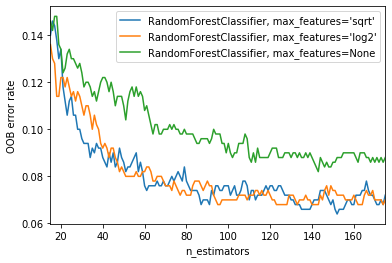

In [7]:
# how do we evaluate a random forest?
# let's compare some forests based on their oob score
# source: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py
import matplotlib.pyplot as plt
from collections import OrderedDict

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
min_estimators = 15
max_estimators = 175
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()